### Imports

In [1]:
%cd ..

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [2]:
!pwd

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.text import *

In [5]:
from ulmfit.pretrain_lm import *

In [6]:
cuda_id = 1
torch.cuda.set_device(cuda_id)

### Preparing data

In [7]:
bs = 20

In [8]:
wiki_data_path = Path('data/wiki/ru-2/')

In [9]:
wiki_data_path.ls()

[PosixPath('data/wiki/ru-2/ru.wiki.test.tokens'),
 PosixPath('data/wiki/ru-2/ru.wiki.valid.tokens'),
 PosixPath('data/wiki/ru-2/ru.wiki.train.tokens'),
 PosixPath('data/wiki/ru-2/models'),
 PosixPath('data/wiki/ru-2/tmp_lm')]

In [9]:
trn_path = wiki_data_path/'ru.wiki.train.tokens'
val_path = wiki_data_path/'ru.wiki.valid.tokens'

In [11]:
data_lm = TextLMDataBunch.from_df(path=wiki_data_path, train_df=read_wiki_articles(trn_path),
                                  valid_df=read_wiki_articles(val_path), 
                                  classes=None, bs=bs, text_cols='texts')

In [15]:
itos, stoi, trn_path = data_lm.vocab.itos, data_lm.vocab.stoi, data_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', data_lm.vocab.itos[:20])

Size of vocabulary: 59184
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', '.', 'в', 'и', '\n\n', 'на', '«', '»', '\n', ')', '(', '—']


In [32]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(3857, 447)

In [22]:
data_lm.train_ds[0][0]

Text xxbos = xxmaj розовая чайка = 
 xxmaj розовая чайка 

 xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде розовых чаек ( & ' xxmaj xxunk & ' ) . 

 xxmaj описание . 
 xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и xxunk розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 

 xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в тундре , на озёрах , чайка часто садится на воду и даже купается . 

 xxmaj вокализация . 
 xxmaj голос этого вида гораздо выше и xxunk , чем у других чаек , и отличается большим разнообразием . xxmaj чаще всего xxunk крик вроде « э - у , э - у » ; xxunk , они издают короткий крик « вя , вя , вя » , если очень xxunk — « xxunk - xxunk » , а при нападении другой чайки того же вида или xxunk

In [24]:
data_lm.train_ds[0][0].data[:10]

array([    2,    28,     4, 19014, 19015,    28,    16,     4, 19014, 19015])

In [11]:
data_lm.show_batch()

idx,text
0,"xxbos \n = xxmaj шишмарёв , xxmaj глеб xxmaj семёнович = \n xxmaj шишмарёв , xxmaj глеб xxmaj семёнович \n\n xxmaj глеб xxmaj семёнович xxmaj шишмарёв ( 1781 — 1835 ) — контр - адмирал , командир гвардейского экипажа , путешественник . \n\n xxmaj родился в 1781 году . xxmaj происходил из дворян xxmaj ржевского уезда , воспитывался в xxmaj морском кадетском корпусе , откуда выпущен гардемарином в 1801 году"
1,"xxunk землями между двумя государствами . к первым годам самостоятельного правления короля xxmaj альфонсо v относятся и безуспешные попытки графа xxmaj кастилии организовать несколько мятежей своих сторонников в xxmaj леоне . \n\n xxmaj окончательный разрыв отношений между графством xxmaj кастилия и королевством xxmaj леон произошёл в xxunk году , когда в xxmaj кастилии начались преследования сторонников союза с xxmaj леоном . xxmaj многие xxunk дворяне бежали ко двору короля xxmaj"
2,"войска xxmaj иоанна v xxmaj xxunk , xxmaj иван xxmaj александр сам стремился овладеть городом . в конце 1342 года xxmaj кантакузину пришлось опять просить помощи xxmaj умура , на этот раз против болгар . в начале 1343 года xxmaj умур прибыл со своим флотом в устье xxmaj дуная . xxmaj он высадился в устье xxmaj марицы , поднялся по её течению и xxunk болгар от xxmaj xxunk . xxmaj"
3,"верстах от xxmaj xxunk , 40 верстах от xxmaj xxunk . \n\n xxmaj культура . \n 12 июля 2009 прошла встреча бывших жителей деревни . \n xxbos \n = xxmaj уилкинсон , xxmaj том = \n xxmaj уилкинсон , xxmaj том \n\n xxmaj то ́ мас xxmaj дже ́ xxunk ( xxmaj том ) xxmaj уи ́ xxunk , известный как xxmaj том xxmaj уилкинсон ( ; род . 5"
4,"граф xxmaj суньер xxup ii и епископ xxmaj xxunk в 889 год прибыли ко двору короля xxmaj эда в xxmaj орлеане и получили от него xxunk хартию , согласно которой епископство xxmaj жирона получало значительные владения в графстве xxmaj осона , а покровителями епархии xxmaj жироны объявлялись графы xxmaj ампурьяса . xxmaj это было единственное появление одного из графов xxmaj испанской марки при дворе короля xxmaj эда за всё время"


In [33]:
data_lm.save('tmp_lm')

In [10]:
data_lm = TextLMDataBunch.load(wiki_data_path, 'tmp_lm', bs=bs)

In [36]:
doc(language_model_learner)

#### Create Learner and train Language Model

In [18]:
learner = language_model_learner(data=data_lm, drop_mult=1.0)

In [19]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [20]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f0e929c6f28>>]

In [21]:
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm')]

In [22]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm')]

In [23]:
learner.unfreeze()

In [24]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


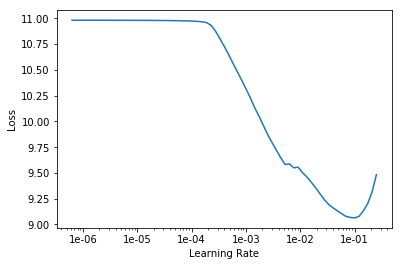

In [25]:
learner.recorder.plot(skip_end=15)

In [26]:
moms=(0.8,0.7)

In [27]:
learner.fit_one_cycle(10, 5e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,5.712268,5.179298,0.296366
2,5.087754,4.683986,0.314654
3,4.970438,4.417627,0.329775
4,4.819845,4.289938,0.344446
5,4.646383,4.191298,0.353953
6,4.492280,4.109755,0.360973
7,4.467671,4.042253,0.369003
8,4.213881,3.995798,0.374132
9,4.056872,3.986120,0.375951
10,3.935030,3.984321,0.376229


In [28]:
learner.save('ru-2-best')

### Fine tune on ruSentEval

In [8]:
rusent_data_path = Path('data/ruSentEval/')

In [9]:
rusent_data_path.ls()

[PosixPath('data/ruSentEval/texts.csv'),
 PosixPath('data/ruSentEval/models'),
 PosixPath('data/ruSentEval/tmp_lm'),
 PosixPath('data/ruSentEval/negative.csv'),
 PosixPath('data/ruSentEval/positive.csv')]

In [12]:
data1_lm = TextLMDataBunch.from_csv(rusent_data_path, 'texts.csv', bs=bs)

In [14]:
itos, stoi, data_path = data1_lm.vocab.itos, data1_lm.vocab.stoi, data1_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])
print(str(data_path))

Size of vocabulary: 54221
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', ')', '(', ':', '/', 'не', '.', 'я', 'и', 'в', '!', '\n']
data/ruSentEval


In [16]:
(data1_lm.path/'models').ls()

[PosixPath('data/ruSentEval/models/itos.pkl'),
 PosixPath('data/ruSentEval/models/ru-2-best.pth')]

In [12]:
len(data1_lm.train_ds), len(data1_lm.valid_ds)

(181467, 45367)

In [18]:
data1_lm.save('tmp_lm')

In [10]:
data1_lm = TextLMDataBunch.load(rusent_data_path, 'tmp_lm', bs=bs)

In [11]:
data1_lm.show_batch()

idx,text
0,"xxbos xxmaj не могу ! ! ! :))) xxup rt @drunktwi : xxmaj не ставь смайлики в конце предложения . xxup будь xxup суровым . xxmaj ставь точки . xxbos xxmaj мальчик мой я скучаю за тобой очень . \n это просто издевательство работать без xxunk этими праздниками . ( http : / / t.co / xxunk xxbos @nicole_hradil даа xxup :d ахаха , не плохо ты там устроилась xxup"
1,"\n хоть и очень вредный ) но ты обещал , что будешь чаще : xxunk , белым и xxunk ; * xxbos я xxup забыла xxup загадать xxup xxunk xxrep 14 е xxrep 8 ( xxbos xxup rt @karrimov : xxmaj кто знает в xxmaj москве рестораны где в меню есть лапша xxup ролтон ? xxmaj нигде не могу найти :( xxbos xxmaj выбрал на # xxmaj amazon классный факс"
2,"бах - бах ( xxbos xxup rt @alxr_gol : xxunk я сейчас так написал , словно я уже старый дед ( ( ( xxbos xxmaj класно погуляли , xxunk , повалялись ! \n хахаха .. я його більше xxunk ес xxrep 5 а ) ) xxbos xxmaj современная экспресс - методика определения сытости кота :) https : / / t.co / xxunk xxbos я не знала что на животными проводят"
3,"xxbos xxmaj кстати , прошло xxunk дня , как парни стали группой :) http : / / t.co / xxunk xxbos xxunk да .. вот у меня уже психоз из - за нг , а еще и др скоро ( xxbos xxmaj xxunk очень xxunk артист , который благодаря xxunk за $ во всем что можно превратился в гавно . xxmaj да простят меня армянские друзья : ) xxbos а"
4,"это с их стороны поступок , исполненный xxunk математической логики и xxunk гражданского xxunk ( xxbos xxup rt xxunk : xxmaj люди я вообще ни понимаю , как кеша могла выиграть ? ! в этом мире все решают гребаные деньги . ( xxbos xxunk он бы столько фактов как про кофе не xxunk ) xxbos xxmaj как я устала от всего этого xxrep 8 ! xxrep 9 ( xxbos xxup"


#### Create Learner and Finetune model from pretrained fnames

In [20]:
pretrained_fnames = ['ru-2-best', 'itos']

In [21]:
learner = language_model_learner(data1_lm, pretrained_fnames=pretrained_fnames, drop_mult=0.3)

Unknown tokens 37462, first 100: ['rt', 't.co', '"', ':(', ':)', ':d', 'блин', ';)', ':-)', ':-(', 'нг', 'сижу', 'ахах', 'бля', 'ахаха', '=)', ':((', '=(', 'о_о', 'болит', ':*', 'пойду', 'скучаю', ':3', 'ладно', 'прям', 'смотрю', 'ахахах', 'пиздец', 'щас', 'блять', 'эх', 'жду', ':))', '\xa0', 'обидно', 'ненавижу', 'твиттер', ':|', 'боюсь', ':(((', 'твит', 'ох', 'нету', 'грустно', '\xa0 ', 'сука', 'капец', 'забыла', 'весело', 'бл', '^_^', 'ddd', 'прости', 'купила', 'ааа', 'тви', 'гулять', 'больно', 'євромайдан', 'лень', ':)))', 'каникулы', 'устала', 'нечего', 'аж', 'обожаю', 'o_o', 'иду', 'фотки', 'наверно', 'ахахаха', 'чувак', 'проснулась', '♥', 'пишу', 'хд', 'бесит', 'вставать', 'делаю', 'твои', 'смогу', 'посмотрела', '️', 'сказали', '^^', 'соскучилась', ':-d', 'смешно', 'заболела', 'вспомнила', 'даа', 'спокойной', 'поздравляю', 'читаю', 'лол', 'иди', 'молодец', 'безумно', ':-']


In [22]:
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm')]

In [24]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [25]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f057c734f28>>]

In [29]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


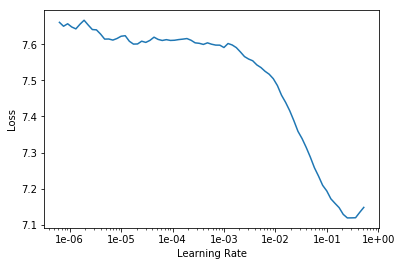

In [30]:
learner.recorder.plot(skip_end=15)

In [31]:
moms = (0.8, 0.7)

In [32]:
learner.fit_one_cycle(1, 3e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.989331,4.743738,0.266576


In [33]:
learner.save('fit_head')

In [34]:
learner.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (181467 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentEval
x: LMTextList (181467 items)
[Text xxbos xxup rt xxunk : 2 часа на санках - xxunk ) прям как в детстве !, Text xxbos xxmaj нашла друга из xxmaj франции , который знает английский и немного xxunk русским ) ) xxmaj он ооочень классный ) ), Text xxbos xxmaj умер xxmaj джонни xxmaj депп . xxmaj проснулась в холодном поту . xxmaj присниться же такое ( ( 
 xxmaj грусть . xxmaj печаль ., Text xxbos каждый раз я боюсь экзаменов 
 и каждый раз нормально их сдаю 

 но сегодня 
 xxup сегодня xxup мне xxup пизда 
 я не знаю нифига (, Text xxbos xxup rt @lisominizul : xxmaj едем , едем е , на военную кафедру :)]...
Path: data/ruSentEval;

Valid: LabelList
y: LMLabel (45367 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentEval
x: LMTextList (45367 items)
[Text xxbos xxunk выкинуть то придется xxu

In [35]:
learner.unfreeze()

In [36]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


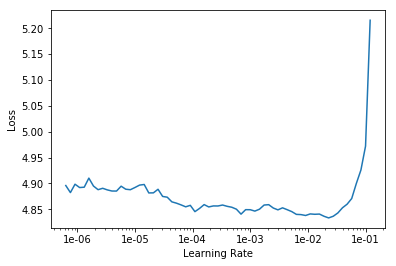

In [37]:
learner.recorder.plot(skip_end=15)

In [38]:
learner.fit_one_cycle(10, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.667617,4.586162,0.280624
2,4.536056,4.465180,0.294646
3,4.463416,4.379823,0.304402
4,4.383000,4.321014,0.311493
5,4.298209,4.281561,0.316598
6,4.194479,4.256127,0.320345
7,4.128749,4.241140,0.323065
8,4.054698,4.234944,0.324466
9,3.988484,4.235610,0.325021
10,3.976133,4.237404,0.324881


In [39]:
learner.save('fine_tuned')

In [40]:
TEXT = "сегодня утром я"
N_WORDS = 10
N_SENTENCES = 2

In [41]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

сегодня утром я квартир нээх @kastiel_misha беднее деградирую пьющих openbox @lisagoldyes бір @720_vozduha
сегодня утром я биологические удивительная байрыг перспективу оживить пятеркой @v_suhareff основания нуок счетчиков


In [42]:
learner.save_encoder('fine_tuned_enc')

### Classifier

In [13]:
rusent_data_path.ls()

[PosixPath('data/ruSentEval/texts.csv'),
 PosixPath('data/ruSentEval/models'),
 PosixPath('data/ruSentEval/tmp_lm'),
 PosixPath('data/ruSentEval/negative.csv'),
 PosixPath('data/ruSentEval/positive.csv')]

In [15]:
data_clas = (TextList.from_csv(path=rusent_data_path, csv_name='texts.csv', cols='text', vocab=data1_lm.vocab)
             .split_from_df()
             .label_from_df(cols='label')
             .databunch(bs=bs))

In [25]:
data_clas.save('tmp_clas')

In [27]:
data_clas = TextClasDataBunch.load(rusent_data_path, 'tmp_clas', bs=bs)

In [28]:
len(data_clas.vocab.itos)

54221

In [29]:
data_clas.show_batch()

text,target
"xxbos @dshvl мм , xxunk как пэрсик \n xxup :d \n я хочу тебя \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n . \n увидеть ! xxup :d \n пришли мне свою фотку , маленький говнюк xxup :d",positive
xxbos xxup rt @bryntsevaekater : xxup линта xxup вангую xxup первый xxup раз : \n xxmaj имя \n xxmaj возраст \n xxmaj цвет глаз \n xxmaj фандом \n xxmaj бонус картинка случайной звезды : ) \n xxmaj только читателям \n # xxup rt # xxup rt # xxup rt …,positive
"xxbos xxmaj xxunk , что бесит вк ? xxmaj когда человек пишет тебе "" xxmaj привет "" , а затем выходит , или когда ты пишешь "" xxmaj привет ) xxmaj как дела ? "" , тебе не пишут "" xxmaj привет """,positive
xxbos xxup rt xxunk : xxmaj юлю снимать сейчас нельзя . xxmaj надо было или не вешать или уже не снимать . xxmaj врагов не радовать . ( # xxmaj євромайдан live at http : / / t.co / xxup xxunk …,negative
"xxbos у xxup нас в xxup россии xxup живут xxup самые xxup xxunk xxup xxunk : xxup на xxup объявление "" xxup кто xxup потерял xxup кошелек с 5000 xxup xxunk 200 000 000 xxup человек .. xxrep 5 )",positive


In [30]:
learner = text_classifier_learner(data=data_clas, drop_mult=0.5)

In [31]:
learner.load_encoder('fine_tuned_enc')

In [32]:
learner.freeze()

In [33]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


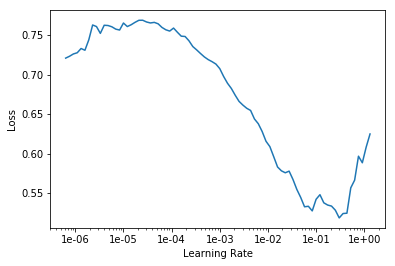

In [34]:
learner.recorder.plot()

In [35]:
moms=(0.8,0.7)


In [36]:
learner.fit_one_cycle(1, 1e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.237269,0.107060,0.964432


In [37]:
learner.save('first')

In [38]:
learner.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (204089 items)
[Category positive, Category positive, Category positive, Category positive, Category positive]...
Path: .
x: TextList (204089 items)
[Text xxbos xxunk хоть я и школота , но поверь , у нас то же самое xxup :d общество xxunk предмет типа ), Text xxbos xxmaj да , все - таки он немного похож на него . xxmaj но мой мальчик все равно лучше : d, Text xxbos xxup rt xxunk : xxmaj ну ты идиотка ) я испугалась за тебя ! ! !, Text xxbos xxup rt xxunk : " xxmaj кто то в углу сидит и погибает от голода , а мы ещё 2 порции взяли , хотя уже и так жрать не хотим " : xxup dd http : / / t.co / xxunk …, Text xxbos xxunk xxmaj вот что значит xxunk xxup :d 
 xxmaj но блин , посмотрев все части , у тебя xxunk ощущение , что авторы курили что - то xxup :d]...
Path: data/ruSentEval;

Valid: LabelList
y: CategoryList (22745 items)
[Category positive, Category positive, Category positive, Category positive, Category positive]...

In [39]:
learner.freeze_to(-2)
learner.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.082304,0.022843,0.989932


In [40]:
learner.save('second')

In [ ]:
learner.load('second')

In [41]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.040941,0.020921,0.989888


In [42]:
learner.save('third')

In [ ]:
learner.load('third')

In [43]:
preds, targets = learner.get_preds()

In [49]:
pred_classes = torch.argmax(preds, dim=1)

In [50]:
from sklearn.metrics import classification_report

In [51]:
print(classification_report(targets, pred_classes))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11216
           1       1.00      0.98      0.99     11529

   micro avg       0.99      0.99      0.99     22745
   macro avg       0.99      0.99      0.99     22745
weighted avg       0.99      0.99      0.99     22745



In [1]:
learner.predict(' какой классный чувак')

NameError: name 'learner' is not defined